In [1]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
import loss_funcs
import cv2 as cv

from utils.image import ImageUtils
from tqdm.auto import tqdm
from collections import defaultdict 

In [2]:
INIT_LOCATION = (0, 1.3, 0.3)

LOSS_FUNCTIONS = [
    loss_funcs.IOU(),
    loss_funcs.MSE(),
    loss_funcs.RMSE(norm="euclidean"),
    loss_funcs.WeightedSum(loss_funcs.IOU(), loss_funcs.RMSE(norm="euclidean")),
    loss_funcs.NMI(bins=50),
    loss_funcs.PSNR(),
    loss_funcs.SSIM(),
    loss_funcs.Hausdorff(),
    loss_funcs.ARE(),
    loss_funcs.VI(),
]


OBJECTS = ["airplane", "hammer", "hand", "headphones", "mouse", "mug", "stapler", "toothpaste"]

ZFAR = 5

In [3]:
def create_viewer(obj_name: str, is_sim: bool = True) -> ViewSampler:
    location = (INIT_LOCATION[0], INIT_LOCATION[2] - 1.3, INIT_LOCATION[2])
    cam_config = CameraConfig(location, rotation=(np.pi / 2, 0, 0), fov=30, zfar=ZFAR)
    if is_sim:
        viewer = ViewSampler(f"data/{obj_name}/world_sim.xml", cam_config, simulation_time=0)
    else:
        viewer = ViewSampler(f"data/{obj_name}/world.xml", cam_config, simulation_time=0)
    return viewer

In [4]:
def generate_positions(count: int, ) -> list[ObjectPosition]:
    orients = OrientUtils.generate_random(count)
    positions = [ObjectPosition(orient, INIT_LOCATION) for orient in orients]
    return positions

In [5]:
def get_views(viewer: ViewSampler, pos1: ObjectPosition, pos2: ObjectPosition, depth: bool) -> tuple[np.ndarray, np.ndarray]:
    img1, _ = viewer.get_view_cropped(pos1, depth=depth, allow_simulation=False)
    img2, _ = viewer.get_view_cropped(pos2, depth=depth, allow_simulation=False)
    return img1, img2

In [6]:
def calc_penalty(num_samples):
    total = 0
    count = 0

    positions1 = generate_positions(num_samples)
    positions2 = generate_positions(num_samples)

    for obj_name in tqdm(OBJECTS):
        with create_viewer(obj_name) as viewer:
            for pos1, pos2 in tqdm(zip(positions1, positions2), total=num_samples):
                img1, img2 = get_views(viewer, pos1, pos2, depth=True)
                pad_shape = np.maximum(img1.shape, img2.shape)
                img1 = ImageUtils.pad_to_shape(img1, pad_shape, pad_value=0)
                img2 = ImageUtils.pad_to_shape(img2, pad_shape, pad_value=0)
                both = (img1 > 0) & (img2 > 0)

                total += np.sum(np.abs(img1[both] - img2[both]))
                count += np.sum(both)

    return total / count

In [7]:
N = 500
positions1 = generate_positions(N)
positions2 = generate_positions(N)

In [8]:
from evaluate import eval_funcs

eval_func = eval_funcs.XorDiff(0.1)
eval_results = []

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=True)
            result = eval_func(img1, img2)
            eval_results.append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
loss_results = defaultdict(list)

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=False)
            for loss_func in LOSS_FUNCTIONS:
                result = loss_func(img1, img2)
                loss_results[loss_func.get_name()].append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
for k, loss_vals in loss_results.items():
    eval_vals = np.asanyarray(eval_results)
    loss_vals = np.asanyarray(loss_vals)
    print(k, np.corrcoef(eval_vals, loss_vals)[0, 1])

IOU 0.5946608918090714
MSE 0.3187203642217811
RMSE 0.497403224713406
 WeightedSum(IOU,RMSE) 0.5714372105133865
NMI 0.557913789515036
PSNR 0.3548357144126852
SSIM -0.07354625488199634
Hausdorff 0.41319428011205556
ARE 0.20602623593445887
VI -0.19711515349375203


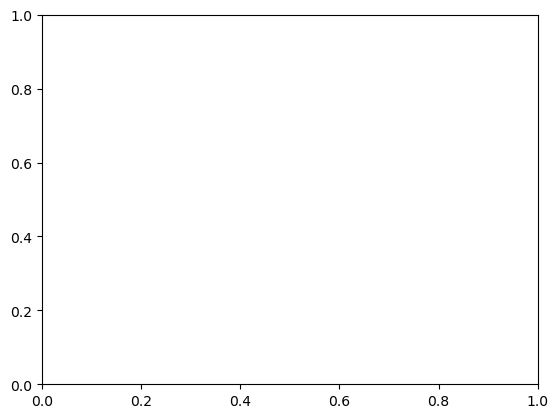

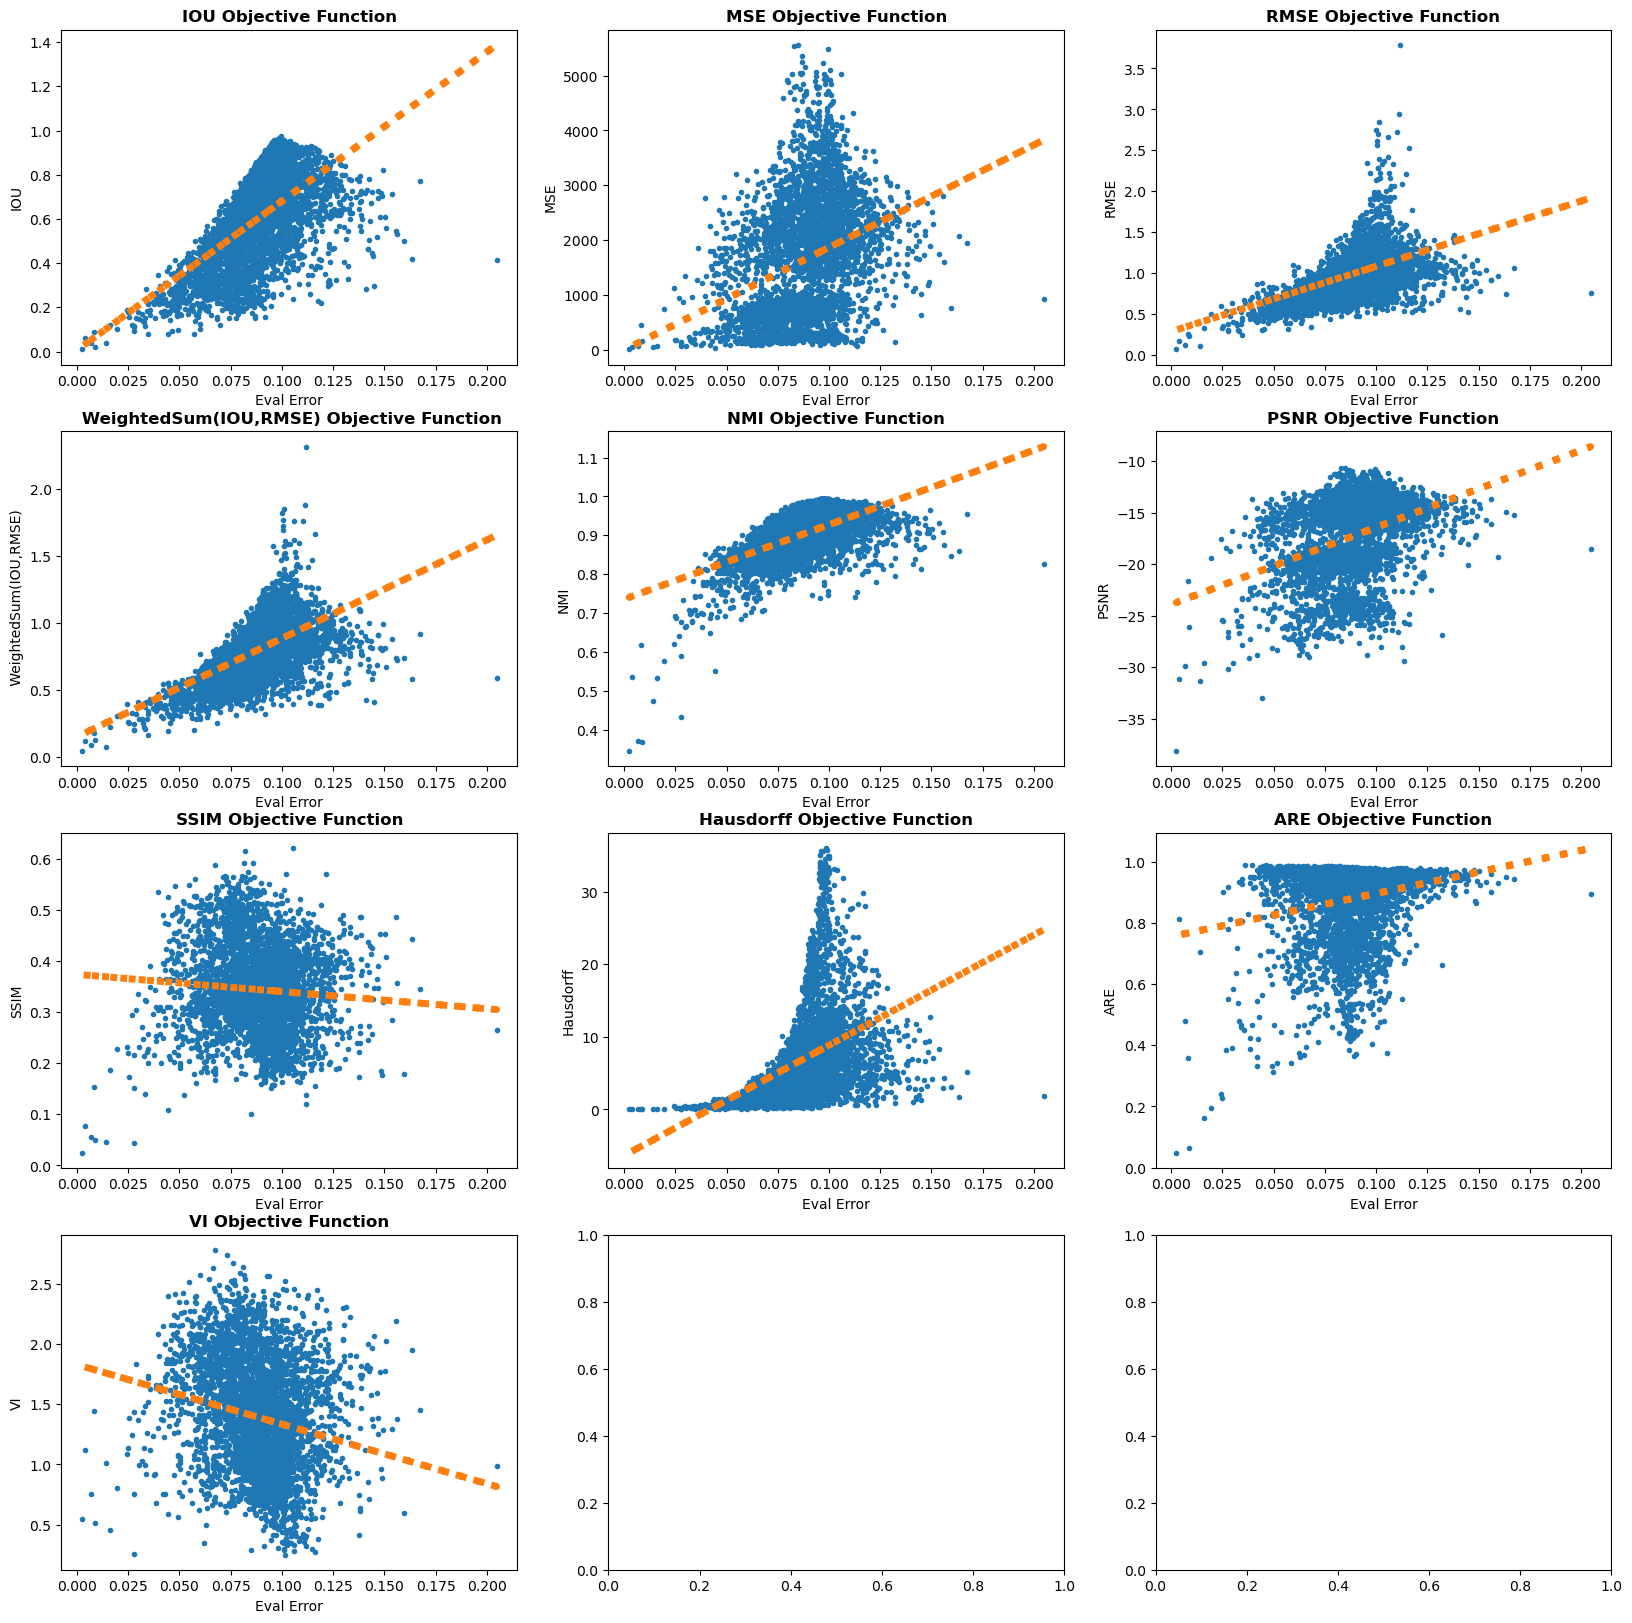

In [11]:
from matplotlib import pyplot as plt

font = {"weight": "normal", "size": 10}

plt.rc("font", **font)
plt.rcParams["text.usetex"] = False

plt.cla()
fig, axes = plt.subplots(4, 3, sharex=False, figsize=(20, 20))

for i, (loss, values) in enumerate(loss_results.items()):
    ax = axes[i // 3, i % 3]
    ax.set_xlabel("Eval Error")
    ax.set_ylabel(loss)
    ax.set_title(f"{loss} Objective Function", fontweight="bold")

    x = eval_results
    y = np.polyval(np.polyfit(x, values, 1), x)

    ax.plot(x, values, ".", label=loss, markersize=6)
    ax.plot(x, y, ":", linewidth=5)

In [12]:
from algs.uniform_sampling import UniformSampling
from evaluate import eval_funcs

alg_config = UniformSampling.Config(time_limit=1000, min_samples=512, randomized=False, silent=True)

eval_positions = generate_positions(100)

results = defaultdict(lambda: defaultdict(list))

SELECTED_LOSSES = [
    loss_funcs.IOU(),
    loss_funcs.RMSE(),
    loss_funcs.WeightedSum(loss_funcs.IOU(), loss_funcs.RMSE()),
    loss_funcs.NMI(),
    loss_funcs.Hausdorff(),
]

SELECTED_LOSSES = [
    loss_funcs.NMI(10),
    loss_funcs.NMI(30),
    loss_funcs.NMI(50),
    loss_funcs.NMI(70),
    loss_funcs.NMI(90),
]

LOSS_NAMES = [
    "NMI-10",
    "NMI-30",
    "NMI-50",
    "NMI-70",
    "NMI-90",
]

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name, True) as sim_viewer, create_viewer(obj_name, False) as world_viewer:
        for loss_func, loss_name in zip(SELECTED_LOSSES, LOSS_NAMES):
            alg = UniformSampling(sim_viewer, loss_func=loss_func)
            evaluator = Evaluator(world_viewer, sim_viewer, eval_func=eval_funcs.XorDiff(0.1))
            losses = evaluator.evaluate(alg, alg_config, eval_positions)
            results[obj_name][loss_name].extend(losses)

  0%|          | 0/8 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: IOU
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: RMSE
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func:  WeightedSum(IOU,RMSE)
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: NMI
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Algorithm: UniformSampling | Objective Func: Hausdorff
Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=512, randomized=False)


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
from utils.io import save_pickle

res_dict = dict()

for k, v in results.items():
    res_dict[k] = dict(v)

#save_pickle("plots/loss_eval_results.pkl", results)

ValueError: error saving object to pickle file: Can't pickle <function <lambda> at 0x7f37f867af20>: attribute lookup <lambda> on __main__ failed

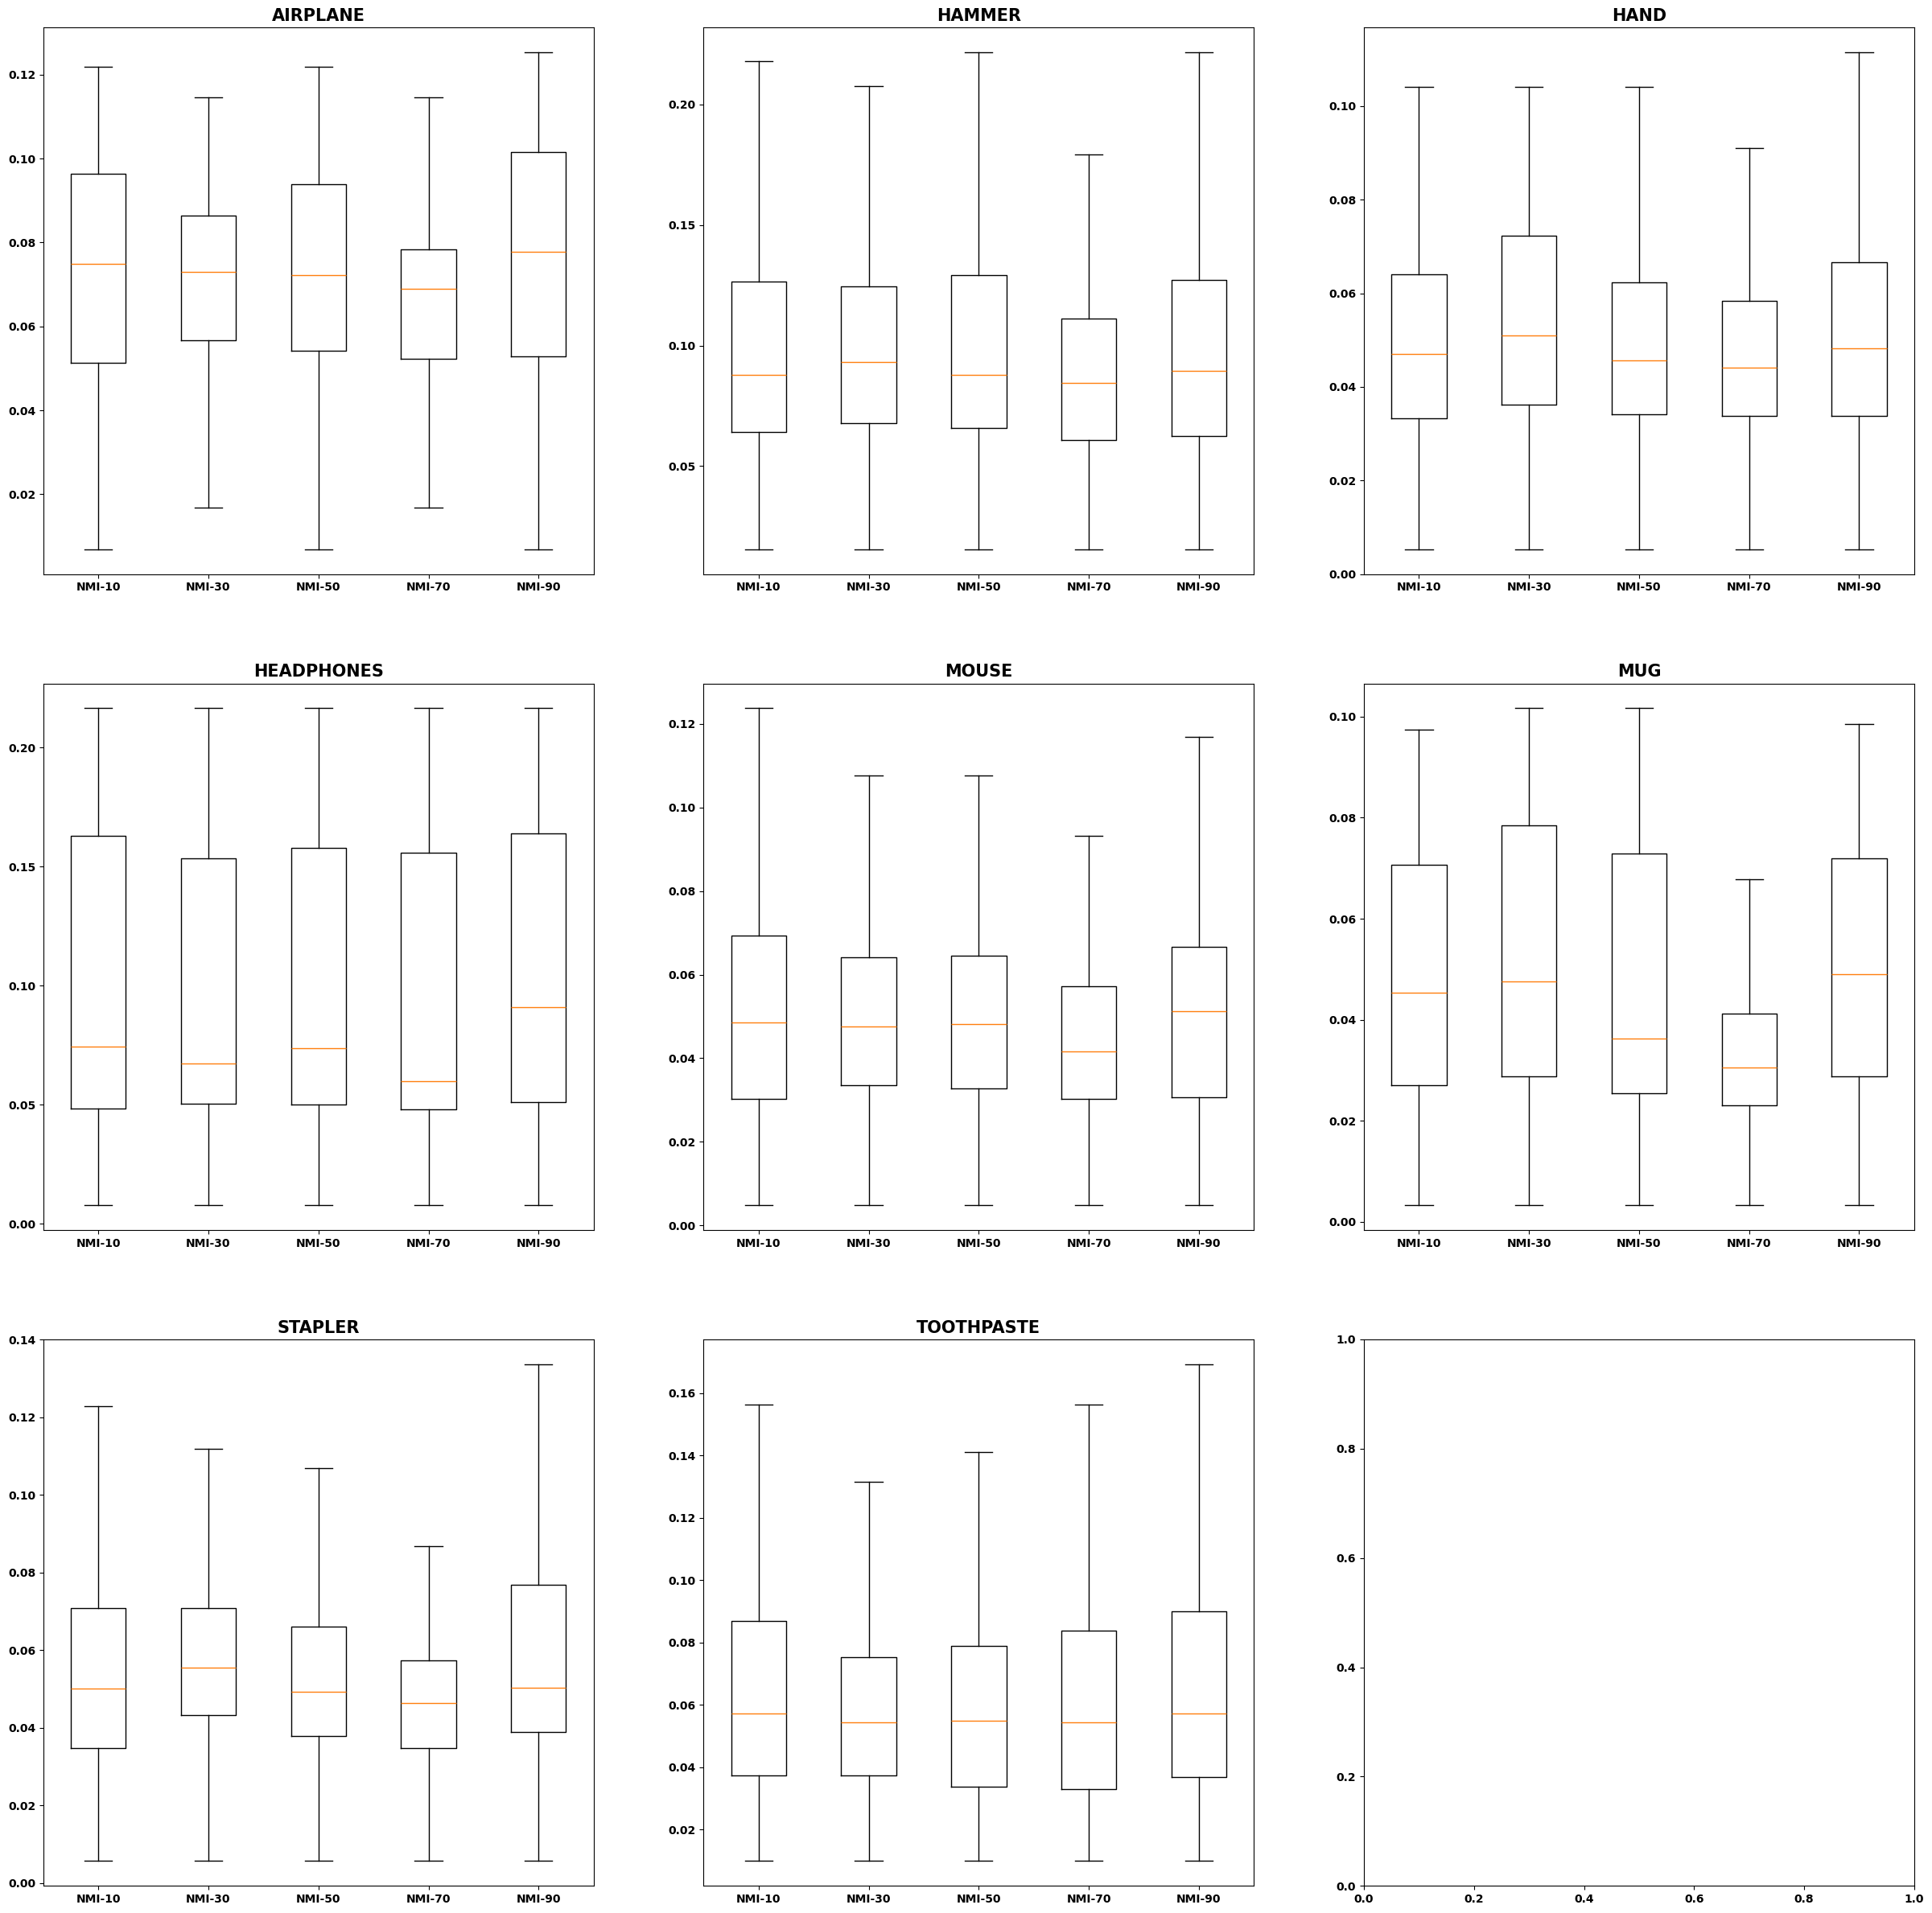

In [79]:
from matplotlib import pyplot as plt

font = {"weight": "bold", "size": 10}

plt.rc("font", **font)

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(30, 30))

for i, object_name in enumerate(OBJECTS):
    ax = axes[i // 3, i % 3]
    ax.set_title(object_name.upper(), fontweight="bold", fontsize=15)

    ax.boxplot(results[object_name].values(), labels=LOSS_NAMES, sym="", patch_artist=False, autorange=True)
    #ax.set_ylabel("Eval Error")

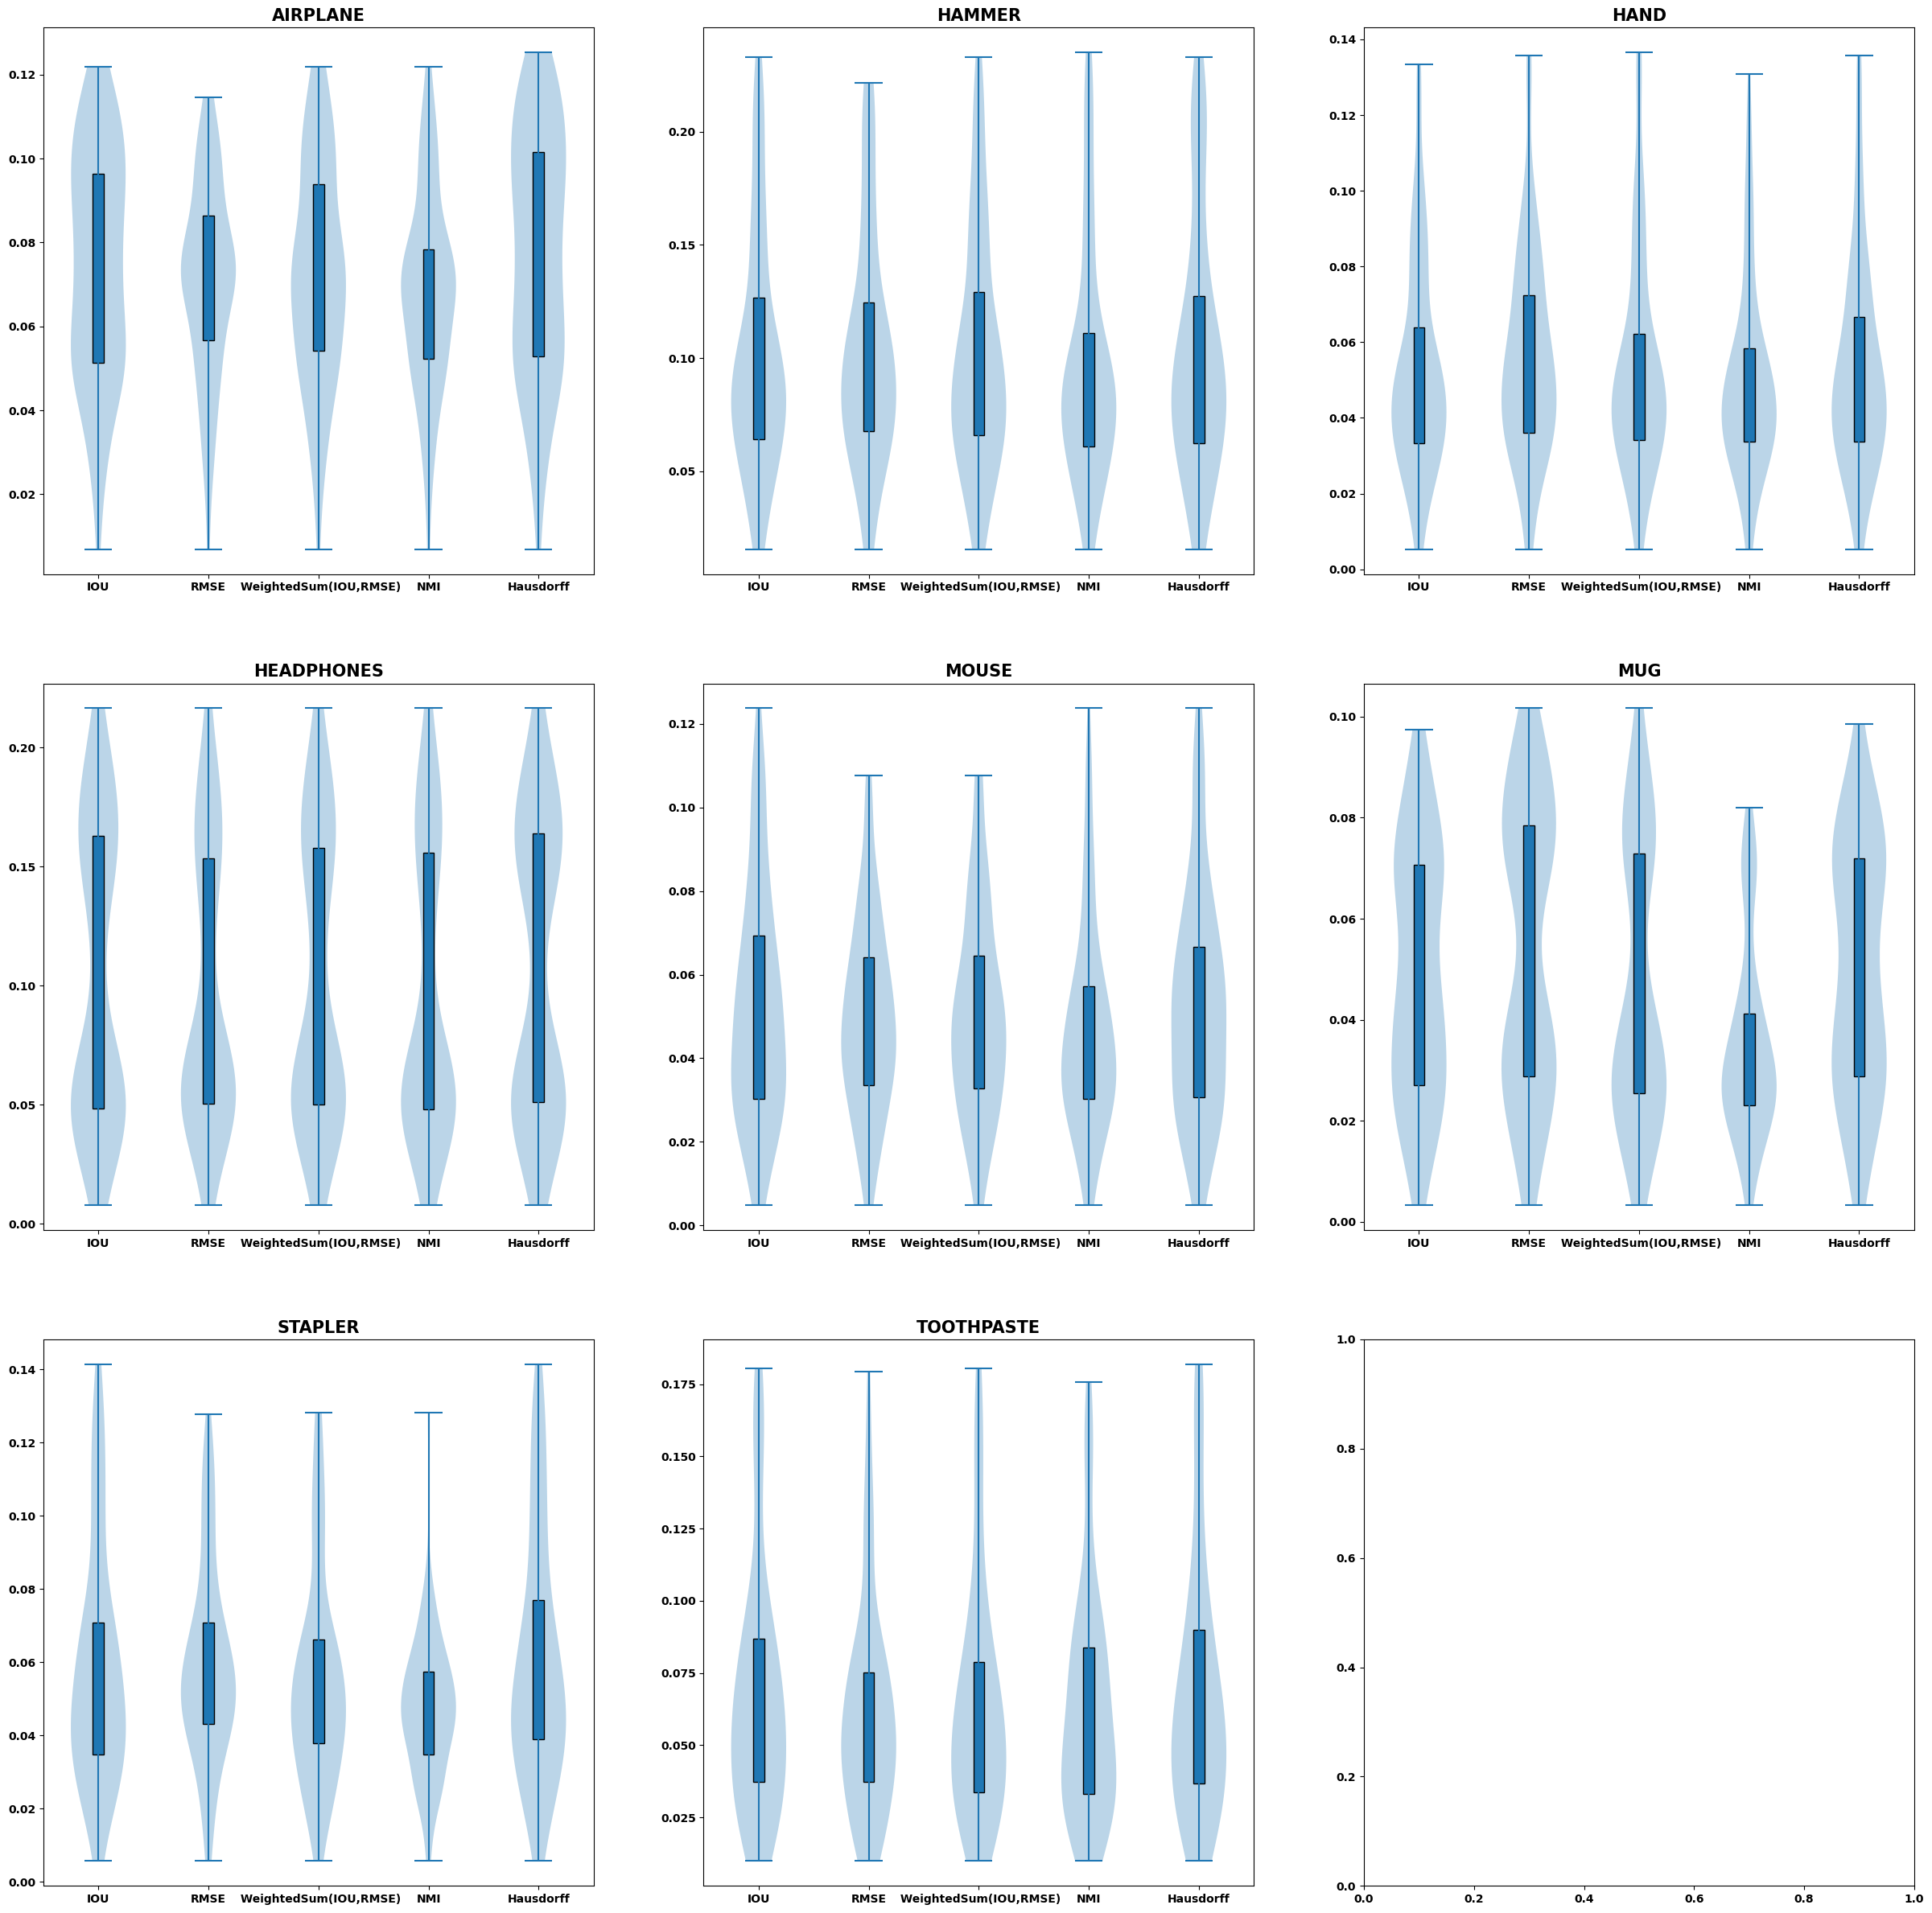

In [76]:
from matplotlib import pyplot as plt

font = {"weight": "bold", "size": 10}

plt.rc("font", **font)

labels = [l.get_name() for l in SELECTED_LOSSES]

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(30, 30))

medianprops = dict(linestyle=None, linewidth=0)
whiskerprops = dict(linewidth=0)
capprops = dict(linewidth=0)

for i, object_name in enumerate(OBJECTS):
    ax = axes[i // 3, i % 3]
    ax.set_title(object_name.upper(), fontweight="bold", fontsize=15)
    bp = ax.boxplot(
        results[object_name].values(),
        widths=0.1,
        sym="",
        patch_artist=True,
        #whis=[5, 95],
        #bootstrap=10000,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
    )

    violin = ax.violinplot(results[object_name].values(), showmeans=False)
    ax.set_xticks([y + 1 for y in range(len(labels))], labels=LOSS_NAMES)